In [1]:
%%capture
%pip install transformers datasets

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset
from tqdm.notebook import tqdm
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset introduction and pre-processing
The classification task will be done on the IMDB review Dataset. Reviews are either labeled "positive" or "negative". The reviews are also quite long on average, so it will be a good opportunity to observe the performance gained on computation time using Linformer. 

In [4]:
from datasets import load_dataset
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased", do_lower_case=True
)
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)
print(dataset[0])

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})
{'review': "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are 

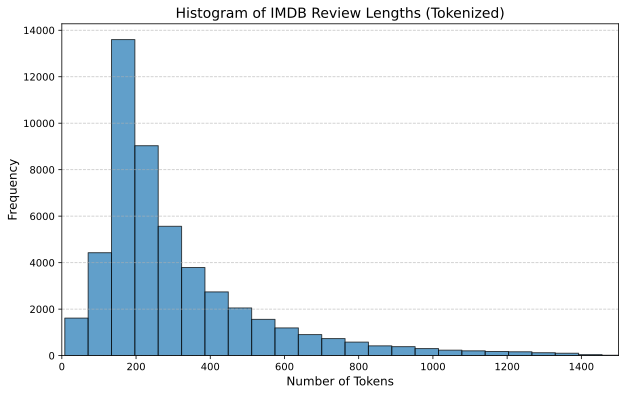

In [5]:
review_lengths = [len(tokenizer.tokenize(review['review'])) for review in dataset]

plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50, edgecolor="k", alpha=0.7)
plt.title("Histogram of IMDB Review Lengths (Tokenized)", fontsize=14)
plt.xlabel("Number of Tokens", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xlim(0,1500)
plt.show()

In [6]:
def preprocessing_fn(x, tokenizer, max_length):
    encoded = tokenizer.encode_plus(
        x["review"],
        add_special_tokens=True,
        truncation=True,
        max_length=max_length,  
        padding="max_length",  
        return_attention_mask=True,  
    )
    # Assign tokenized data and label
    return {
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
        "label": 1 if x["sentiment"] == "positive" else 0,
    }


In [7]:
n_samples = 50000  # The number of training examples
max_length = 1024 # The maximum length of the input sequence

# Shuffle the data
dataset = dataset.shuffle()

# Select n_samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

# Print a sample to verify
print(splitted_dataset[0])

# Remove useless columns 
splitted_dataset = splitted_dataset.select_columns(["input_ids", "attention_mask", "label"])

# Split the train and validation sets
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'review': 'Silly, hilarious, tragic, sad, inevitable.<br /><br />A group of down-and-outs team up with a "seasoned" crook to elevate themselves out of their poverty. Great idea...if you ignore the screwup factor.<br /><br />Nice to see George Clooney doing something genuinely funny for a change. The casting is perfect and the acting standards very high. Although it could be said that the motley crew subject isn\'t new, I think this movie handles it in an interesting and unique way. Sufficiently so that it stands out from what has gone before.<br /><br />Very well done guys.', 'sentiment': 'positive', 'input_ids': [101, 10021, 1010, 26316, 1010, 13800, 1010, 6517, 1010, 13418, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1037, 2177, 1997, 2091, 1011, 1998, 1011, 21100, 2136, 2039, 2007, 1037, 1000, 28223, 1000, 19302, 2000, 3449, 13331, 2618, 3209, 2041, 1997, 2037, 5635, 1012, 2307, 2801, 1012, 1012, 1012, 2065, 2017, 8568, 1996, 11224, 6279, 5387, 1012, 1026, 7987, 1013, 102

### DataLoader

In [8]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = self.tokenizer.pad(
            batch, padding="longest", max_length=max_length, return_tensors="pt"
        )
        return features

data_collator = DataCollator(tokenizer)

batch_size = 32 # GPU can handle this much

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator, shuffle=True
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

batch = next(iter(train_dataloader))
print("Input IDs:", batch["input_ids"][1])  
print("Mask:", batch["attention_mask"][1])  
print("Labels:", batch["label"][1])  
print("Input IDs length:", batch["input_ids"][1].size())  
print("Mask length:", batch["attention_mask"][1].size())  
print("Labels length:", batch["label"][1].size())  

Input IDs: tensor([ 101, 1037, 2567,  ...,    0,    0,    0])
Mask: tensor([1, 1, 1,  ..., 0, 0, 0])
Labels: tensor(1)
Input IDs length: torch.Size([1024])
Mask length: torch.Size([1024])
Labels length: torch.Size([])


## Model Implementation
In this section, we implement a transformer architecture that can use both the traditionnal multi-head Attention and Linformer multi-head Attention

#### Weights initialization

In [9]:
def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, mean=0, std=0.02)
    elif isinstance(module, nn.LayerNorm):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)

#### Feed-Forward

In [10]:
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(FeedForward, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),  
            nn.Dropout(dropout),  
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

#### Classic Multi-Head Self-Attention 

We use masking so that that the model does not attend to padding token 

In [11]:
class Multi_Head_Attention(nn.Module):
    def __init__(self, d, n_heads, dropout=0.3):
        super(Multi_Head_Attention,self).__init__()
        assert d % n_heads == 0, "Embedding dimension must be divisible by the number of heads"
        
        self.n_heads = n_heads
        self.d_heads = d // n_heads  # Dimension per head

        self.q_proj = nn.Linear(d, d)
        self.k_proj = nn.Linear(d, d)
        self.v_proj = nn.Linear(d, d)
        self.out_proj = nn.Linear(d, d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attention_mask=None):
        batch_size, seq_len, d = x.shape
        d_heads = self.d_heads

        # Linear projections
        Q = self.q_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)
        K = self.k_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)
        V = self.v_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)

        # Attention scores
        score = Q @ K.transpose(-1, -2) * (d_heads**-0.5)

        # Apply Mask
        if attention_mask is not None:
            expanded_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            score = score.masked_fill(expanded_mask == 0, float('-inf'))

        score = torch.softmax(score, dim=-1)
        score = self.dropout(score) 

        # Attention output
        attention = score @ V  # (batch_size, n_heads, seq_len, d_heads)
        attention = attention.transpose(1, 2).reshape(batch_size, seq_len, d)  # Merge heads
        out = self.out_proj(attention) 
        return out

#### Linformer Multi-Head Self-Attention

Masking but be done differently here since the score matrix is not of dimension $n*n$ anymore. Instead, we apply the mask to K and V directly

In [12]:
class Multi_Head_Attention_Linformer(nn.Module):
    def __init__(self, input_size, d_heads, d, dim_k, n_heads, dropout):
        super(Multi_Head_Attention_Linformer, self).__init__()
        assert d % n_heads == 0, "Embedding dimension must be divisible by the number of heads"

        self.n_heads = n_heads
        self.d_heads = d_heads
        self.dim_k = dim_k
        self.d = d
        self.out_proj = nn.Linear(d, d)

        self.q_proj = nn.Linear(d, d_heads * n_heads)
        self.k_proj = nn.Linear(d, d_heads * n_heads)
        self.v_proj = nn.Linear(d, d_heads * n_heads)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, E, F, attention_mask=None):
        batch_size, seq_len, _ = x.shape

        # Linear projections
        Q = self.q_proj(x).reshape(batch_size, seq_len, self.n_heads, self.d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)
        K = self.k_proj(x).reshape(batch_size, seq_len, self.n_heads, self.d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)
        V = self.v_proj(x).reshape(batch_size, seq_len, self.n_heads, self.d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)

        if attention_mask is not None:
            mask = attention_mask[:, None, :, None]  # (B, 1, seq_len, 1)
            K = K * mask  
            V = V * mask 

        # Project K and V using E and F
        K = (K.transpose(-2, -1) @ E).transpose(-2, -1)  # (batch_size, n_heads, seq_len, dim_k)
        V = (V.transpose(-2, -1) @ F).transpose(-2, -1)  # (batch_size, n_heads, seq_len, dim_k)

        # Attention scores
        score = (Q @ K.transpose(-2, -1)) * (self.d_heads**-0.5)
        score = torch.softmax(score, dim=-1)
        score = self.dropout(score)

        # Attention output
        attention = score @ V  # (batch_size, n_heads, seq_len, d_heads)
        out = attention.transpose(1, 2).reshape(batch_size, seq_len, -1)  # (batch_size, seq_len, d_heads * n_heads)
        out = self.out_proj(out)
        return out


### Transformer Layer 

In [13]:
class TransformerLayer(nn.Module):
    def __init__(self, d, d_ff, seq_len, k_dim, dropout=0.3, n_heads=8, Linformer_Mode=False):
        super().__init__()

        if Linformer_Mode:

            self.attention = Multi_Head_Attention_Linformer(
                input_size=seq_len, 
                d_heads=d // n_heads, 
                d=d,  
                dim_k=k_dim,  
                n_heads=n_heads,  
                dropout=dropout
            )
        else:
            self.attention = Multi_Head_Attention(d,n_heads, dropout)

        self.feedforward = FeedForward(d, d_ff, d, dropout=dropout)
        self.pre_attention_norm = nn.LayerNorm(d)
        self.post_attention_norm = nn.LayerNorm(d)

    def forward(self, x, attention_mask=None, E=None, F=None):
        
        # Attention with residual connection
        normed_x = self.pre_attention_norm(x)
        if isinstance(self.attention, Multi_Head_Attention_Linformer):
            attention = self.attention(normed_x, E, F, attention_mask)  # Linformer attention
        else:
            attention = self.attention(normed_x, attention_mask)  # Classic Transformer attention
        y = normed_x + attention

        # Feedforward with residual connection
        normed_y = self.post_attention_norm(y)
        ff_y = self.feedforward(normed_y)
        return normed_y + ff_y

### Classification Head
The classification head and Transformer Layer will be used by both models. We can easily choose either one by setting Linformer_mode parameter on True or False. We will use the Layerwise sharing of the projections E and F strategy

In [14]:
# For the initialization of the Projections
def init_(tensor):
    dim = tensor.shape[-1]
    std = 1 / math.sqrt(dim)
    tensor.uniform_(-std, std)
    return tensor

class Transformer_Classif(nn.Module):
    def __init__(self, d, d_ff, n_classes, vocab_size, max_len=512, k_dim=128, drop=0.3, num_layers=4, n_heads=8, Linformer_Mode=False):
        super().__init__()
        self.wordembeddings = nn.Embedding(vocab_size, d)
        self.position_embeddings = nn.Embedding(num_embeddings=max_len, embedding_dim=d)  
        self.dropout = nn.Dropout(drop)
        self.max_len = max_len
        self.Linformer_Mode = Linformer_Mode

        # Stack of Transformer Layers
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(d, d_ff, max_len, k_dim, drop, n_heads, Linformer_Mode=Linformer_Mode) for _ in range(num_layers)
        ])
        self.classif = nn.Linear(d, n_classes)

        if Linformer_Mode:
        # Linear projection matrices for K and V (Layer Wise Sharing strategy)
            self.E = nn.Parameter(torch.empty(max_len, k_dim))
            self.F = nn.Parameter(torch.empty(max_len, k_dim))

        # Weight initialization
        self.apply(initialize_weights)

    def forward(self, x, attention_mask=None):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Truncate input if it exceeds max_len
        if seq_len > self.max_len:
            x = x[:, :self.max_len]  
            attention_mask = attention_mask[:, :self.max_len] if attention_mask is not None else None
            seq_len = self.max_len

            if self.Linformer_Mode:
                E, F = self.E[:seq_len, :].to(device), self.F[:seq_len, :].to(device)

        # Word and positional embeddings
        X = self.wordembeddings(x)  # (batch_size, seq_len, d)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        position_vectors = self.position_embeddings(positions)  # (batch_size, seq_len, d)
        X = self.dropout(X + position_vectors)

        # Loop over Transformer Layers
        for layer in self.transformer_layers:
            if self.Linformer_Mode:
                X = layer(X, attention_mask, self.E, self.F)
            else:
                X = layer(X, attention_mask)

        cls_representation = X[:, 0, :]  # (batch_size, d)
        cls_representation = self.dropout(cls_representation)

        # Classification layer
        logits = self.classif(cls_representation)  # (batch_size, n_classes)
        return logits

#### Testing

In [15]:
seq_len = 512
batch_size = 8
vocab_size = 30522

x = torch.randint(0, vocab_size, (batch_size, seq_len))

model = Transformer_Classif(
    d=128,
    d_ff=4*128,
    n_classes=2,
    vocab_size=30522,
    max_len=512,
    k_dim=0,
    drop=0.2,
    num_layers=1,
    n_heads=8,
    Linformer_Mode = False
)

logits = model(x)
print("Logits shape:", logits.shape)  # Expected: (batch_size, n_classes)
print("Logits:", logits)

Logits shape: torch.Size([8, 2])
Logits: tensor([[ 0.6602,  2.4435],
        [ 0.9324,  1.4529],
        [-0.4085, -1.4657],
        [ 0.4259, -0.1471],
        [-0.2625,  0.3034],
        [ 0.7041,  0.2468],
        [ 0.0139, -0.3234],
        [ 0.9513, -3.3243]], grad_fn=<AddmmBackward0>)


In [16]:
seq_len = 512
batch_size = 8
vocab_size = 30522

x = torch.randint(0, vocab_size, (batch_size, seq_len))

model = Transformer_Classif(
    d=128,
    d_ff=4*128,
    n_classes=2,
    vocab_size=30522,
    max_len=512,
    k_dim=128,
    drop=0.2,
    num_layers=1,
    n_heads=8,
    Linformer_Mode = True
)

logits = model(x)
print("Logits shape:", logits.shape)  # Expected: (batch_size, n_classes)
print("Logits:", logits)

Logits shape: torch.Size([8, 2])
Logits: tensor([[ 3.4012,  4.9622],
        [-1.2202, -0.4575],
        [-0.6483,  1.3915],
        [ 3.2574,  1.8546],
        [ 2.0831, -0.4664],
        [ 1.8120,  0.8154],
        [-2.2378,  0.7122],
        [-0.1411,  0.8593]], grad_fn=<AddmmBackward0>)


## Training Functions

In [17]:
def compute_accuracy(predictions, labels):
    pred = predictions.argmax(dim=1)  
    correct = (labels == pred).sum().item()
    return correct

def train_one_epoch(dataloader, model, optimizer, loss_function):
    model.train()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    for batch in tqdm(dataloader, leave=True):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        
        # Forward pass with attention_mask
        probs = model(batch["input_ids"], attention_mask=batch["attention_mask"]) 
        gold = batch["label"]  

        correct += compute_accuracy(probs, gold)
        loss = loss_function(probs, gold) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_train  
    return avg_loss, avg_accuracy


def validation_step(dataloader, model, loss_function):
    model.eval()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    with torch.no_grad():
        for batch in tqdm(dataloader, leave=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass with attention_mask
            probs = model(batch["input_ids"], attention_mask=batch["attention_mask"])  
            gold = batch["label"]

            correct += compute_accuracy(probs, gold)
            loss = loss_function(probs, gold)
            total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_valid  
    return avg_loss, avg_accuracy


def train(model, train_dataloader, valid_dataloader, lr=0.0005, n_epochs=3, wd = 1e-4, plot=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # Track training loss, training accuracy, validation loss and validation accuracy and plot in the end
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train_one_epoch(
            train_dataloader, model, optimizer, criterion
        )
        valid_loss, valid_accuracy = validation_step(valid_dataloader, model, criterion)
        print(
            f"Epoch {epoch + 1}: train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_accuracy: {valid_accuracy:.4f}"
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
    if plot : 
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="train loss")
        plt.plot(valid_losses, label="valid loss")
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label="train accuracy")
        plt.plot(valid_accuracies, label="valid accuracy")
        plt.legend()
    return valid_accuracies

## Configuration of the models 

In [18]:
config_classic = {
    "d": 512,
    "d_ff": 4 * 512,
    "vocab_size": 30522,
    "max_len": max_length,  # Can be changed to any value below max_length
    "k_dim": 0,
    "drop": 0.15,
    "num_layers": 2,
    "n_heads": 8,
    "Linformer_Mode": False
}

config_linformer = {
    "d": 512,
    "d_ff": 4 * 512,
    "vocab_size": 30522,
    "max_len": max_length,
    "k_dim": 256,
    "drop": 0.15,
    "num_layers": 2,
    "n_heads": 8,
    "Linformer_Mode": True
}
torch.cuda.empty_cache()

## Training

### Classic Transformer

Number of learnable parameters: 22.46M


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.6135, train_accuracy: 67.7100, valid_loss: 0.3644, valid_accuracy: 84.1300


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3564, train_accuracy: 84.3425, valid_loss: 0.2952, valid_accuracy: 88.4200


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2748, train_accuracy: 88.7050, valid_loss: 0.2772, valid_accuracy: 89.2500


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: train_loss: 0.2274, train_accuracy: 90.9625, valid_loss: 0.2804, valid_accuracy: 89.5200


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: train_loss: 0.1960, train_accuracy: 92.2450, valid_loss: 0.2873, valid_accuracy: 89.5000
Time to train : 1437.12s


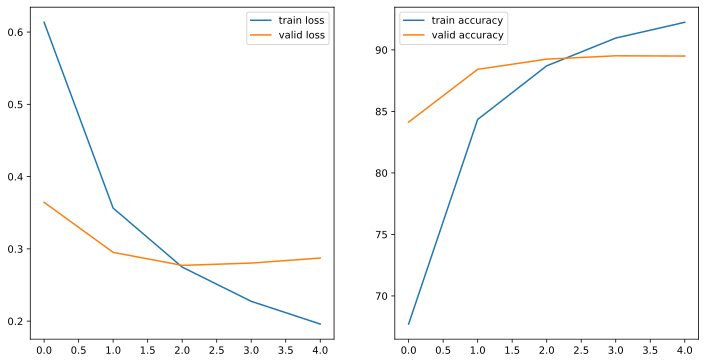

In [18]:
# Initialize model
model_classic = Transformer_Classif(n_classes=2,**config_classic)
model_classic.to(device)

# Number of Parameters 
total_params = sum(p.numel() for p in model_classic.parameters() if p.requires_grad)
print(f"Number of learnable parameters: {total_params / 1e6:.2f}M")

# Training + computation time recording
start_time = time.time()
if __name__ == '__main__':
    train(model_classic, train_dataloader, valid_dataloader,lr=0.00001, n_epochs=5, wd=1e-3)
end_time = time.time()
loop_time = (end_time - start_time)
print(f"Time to train : {loop_time:.2f}s")
torch.cuda.empty_cache()

### Linformer model

Number of learnable parameters: 22.98M


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.6925, train_accuracy: 60.1200, valid_loss: 0.3758, valid_accuracy: 84.5000


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3451, train_accuracy: 85.6400, valid_loss: 0.3169, valid_accuracy: 87.1900


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2618, train_accuracy: 89.4550, valid_loss: 0.2959, valid_accuracy: 88.8800


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: train_loss: 0.2221, train_accuracy: 91.3125, valid_loss: 0.3017, valid_accuracy: 88.9100


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: train_loss: 0.1879, train_accuracy: 92.6900, valid_loss: 0.3102, valid_accuracy: 89.4100
Time to train : 946.16s


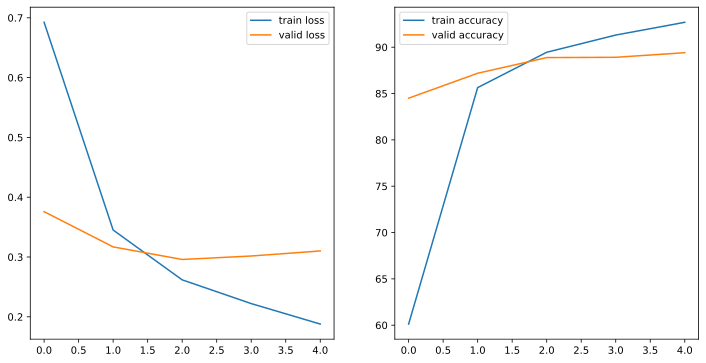

In [19]:
# Initialize model
model_linformer = Transformer_Classif(n_classes=2,**config_linformer)
model_linformer.to(device)

# Number of Parameters 
total_params = sum(p.numel() for p in model_linformer.parameters() if p.requires_grad)
print(f"Number of learnable parameters: {total_params / 1e6:.2f}M")

#Training + computation time recording
start_time = time.time()
if __name__ == '__main__':
    train(model_linformer, train_dataloader, valid_dataloader,lr=0.00001, n_epochs=5, wd=1e-3)
end_time = time.time()
loop_time = (end_time - start_time)
print(f"Time to train : {loop_time:.2f}s")
torch.cuda.empty_cache()

## Ablation Study
In this part, we will study accuracy and computation time for different values of $n$ and $k$. We need to split the data again, but using a training set of size $25000$ and a validation set of size $25000$ to get results that are somewhat more accurate without having to use k-fold cross validation (which would give much more reliable results)

In [25]:
n_samples = 50000  # The number of training examples
max_length = 1024

# Shuffle the data
dataset = dataset.shuffle()

# Select n_samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

# Print a sample to verify
print(splitted_dataset[0])

# Remove useless columns 
splitted_dataset = splitted_dataset.select_columns(["input_ids", "attention_mask", "label"])

# Split the train and validation sets
splitted_dataset = splitted_dataset.train_test_split(test_size=0.5)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'review': "First, let me say that although I generally appreciate Mike Judge's work, I've been merely tepid in my response to Office Space, King of the Hill, and Beavis and Butthead. I generally prefer more intelligent comedy, and therein lies the irony with respect to Idiocracy.<br /><br />In a future world where the embodiment of Beavis and Butthead's views, basest instincts, and intellectual capacities are the framework of a chaotic, messy, semi-Mad Max semi-Blade Runner society, where every trailer-trash guy's fantasy becomes reality, a man with even average intelligence is threatening and accused of talking gay, and the mob mentality takes over. And this world is also incredibly funny.<br /><br />Yes, it's obvious that Carl's Jr., Starbucks, Costco and Fuddruckers executives will be horrified at the twisted values given their products in the year 2505.<br /><br />There were some missed opportunities with the film, and the relationship between the time travelers - the other being 

In [26]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = self.tokenizer.pad(
            batch, padding="longest", max_length=1024, return_tensors="pt"
        )
        return features

data_collator = DataCollator(tokenizer)

batch_size = 32 # GPU can handle this much

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator, shuffle=True
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

In [27]:
ns = [256, 512, 1024]
ks = [64,128,256,512]

results_acc = np.zeros(12)
result_time = np.zeros(12)

i=0
for n in ns:
    config_classic = {
    "d": 256,
    "d_ff": 4 * 256,
    "vocab_size": 30522,
    "max_len": n,
    "k_dim": 0,
    "drop": 0.15,
    "num_layers": 2,
    "n_heads": 4,
    "Linformer_Mode": False
}

    model_classic = Transformer_Classif(n_classes=2,**config_classic)
    model_classic.to(device)
    print("")
    print(f"Classic Transformer : n={n}")
    start_time = time.time()
    acc = np.max(train(model_classic, train_dataloader, valid_dataloader,lr=0.00002, n_epochs=3, wd=1e-3,plot=False))
    torch.cuda.empty_cache()
    end_time = time.time()
    loop_time = (end_time - start_time)
    results_acc[i] = acc
    result_time[i] = loop_time
    i+=1

    for k in ks:

        if (k==512 and n==512) or (k==256 and n==256) or (k==512 and n==256):
            break 

        config_linformer = {
            "d": 256,
            "d_ff": 4 * 256,
            "vocab_size": 30522,
            "max_len": n,
            "k_dim": k,
            "drop": 0.15,
            "num_layers": 2,
            "n_heads": 4,
            "Linformer_Mode": True
        }

        model_linformer = Transformer_Classif(n_classes=2,**config_linformer)
        model_linformer.to(device)
        print("")
        print(f"Linformer : n={n}, k={k}")
        start_time = time.time()
        acc = np.max(train(model_linformer, train_dataloader, valid_dataloader,lr=0.00002, n_epochs=3, wd=1e-3, plot=False))
        torch.cuda.empty_cache()
        end_time = time.time()
        loop_time = (end_time - start_time)
        results_acc[i] = acc
        result_time[i] = loop_time
        i+=1



Classic Transformer : n=256


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.6834, train_accuracy: 62.3280, valid_loss: 0.4712, valid_accuracy: 77.5480


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.4077, train_accuracy: 81.3640, valid_loss: 0.3608, valid_accuracy: 84.7320


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.3039, train_accuracy: 86.9360, valid_loss: 0.3358, valid_accuracy: 86.2040

Linformer : n=256, k=64


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7357, train_accuracy: 55.7760, valid_loss: 0.4652, valid_accuracy: 78.1320


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3871, train_accuracy: 83.0320, valid_loss: 0.3512, valid_accuracy: 85.5080


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2767, train_accuracy: 88.8040, valid_loss: 0.3439, valid_accuracy: 86.3320

Linformer : n=256, k=128


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7934, train_accuracy: 50.3160, valid_loss: 0.6997, valid_accuracy: 49.9360


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.4879, train_accuracy: 75.1600, valid_loss: 0.4062, valid_accuracy: 82.5480


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2824, train_accuracy: 88.5400, valid_loss: 0.3627, valid_accuracy: 85.6720

Classic Transformer : n=512


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.6684, train_accuracy: 63.6960, valid_loss: 0.4303, valid_accuracy: 80.3600


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3695, train_accuracy: 83.6200, valid_loss: 0.3450, valid_accuracy: 85.5600


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2700, train_accuracy: 88.9040, valid_loss: 0.3119, valid_accuracy: 87.8240

Linformer : n=512, k=64


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7509, train_accuracy: 55.3440, valid_loss: 0.4387, valid_accuracy: 80.9760


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3652, train_accuracy: 84.2480, valid_loss: 0.3382, valid_accuracy: 86.7080


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2502, train_accuracy: 90.2640, valid_loss: 0.3186, valid_accuracy: 88.0080

Linformer : n=512, k=128


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7868, train_accuracy: 52.1960, valid_loss: 0.6075, valid_accuracy: 66.3400


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3910, train_accuracy: 82.8280, valid_loss: 0.3273, valid_accuracy: 87.1560


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2528, train_accuracy: 90.0600, valid_loss: 0.3232, valid_accuracy: 87.9800

Linformer : n=512, k=256


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7227, train_accuracy: 56.2080, valid_loss: 0.4226, valid_accuracy: 81.5800


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3527, train_accuracy: 84.8560, valid_loss: 0.3184, valid_accuracy: 87.3320


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2444, train_accuracy: 90.3000, valid_loss: 0.3747, valid_accuracy: 86.4000

Classic Transformer : n=1024


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.6436, train_accuracy: 64.7760, valid_loss: 0.3909, valid_accuracy: 82.7880


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3520, train_accuracy: 84.7840, valid_loss: 0.3518, valid_accuracy: 85.5160


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2542, train_accuracy: 89.6640, valid_loss: 0.3377, valid_accuracy: 86.8760

Linformer : n=1024, k=64


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7707, train_accuracy: 52.2640, valid_loss: 0.5222, valid_accuracy: 75.6760


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3804, train_accuracy: 83.4520, valid_loss: 0.3260, valid_accuracy: 87.0200


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2461, train_accuracy: 90.0720, valid_loss: 0.3641, valid_accuracy: 86.6560

Linformer : n=1024, k=128


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss: nan, train_accuracy: 50.0640, valid_loss: nan, valid_accuracy: 49.9360


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss: nan, train_accuracy: 50.0640, valid_loss: nan, valid_accuracy: 49.9360


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss: nan, train_accuracy: 50.0640, valid_loss: nan, valid_accuracy: 49.9360

Linformer : n=1024, k=256


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7259, train_accuracy: 58.7640, valid_loss: 0.3899, valid_accuracy: 83.6360


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3405, train_accuracy: 85.6680, valid_loss: 0.3169, valid_accuracy: 87.5240


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2378, train_accuracy: 90.6120, valid_loss: 0.3194, valid_accuracy: 87.9600

Linformer : n=1024, k=512


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7132, train_accuracy: 58.8560, valid_loss: 0.4372, valid_accuracy: 81.5960


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3477, train_accuracy: 85.3640, valid_loss: 0.4012, valid_accuracy: 83.6840


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2467, train_accuracy: 90.1720, valid_loss: 0.3309, valid_accuracy: 87.4280


In [28]:
import pandas as pd

indices = [
    "Classic Transformer n=256",
    "Linformer n=256 k=64",
    "Linformer n=256 k=128",
    "Classic Transformer n=512",
    "Linformer n=512 k=64",
    "Linformer n=512 k=128",
    "Linformer n=512 k=256",
    "Classic Transformer n=1024",
    "Linformer n=1024 k=64",
    "Linformer n=1024 k=128",
    "Linformer n=1024 k=256",
    "Linformer n=1024 k=512"
]

dataframe = pd.DataFrame({
    "Accuracy": results_acc,
    "Computation Time (s)": result_time
}, index=indices)

dataframe.round(2)

,Accuracy,Computation Time (s)
Classic Transformer n=256,86.20,139.49
Linformer n=256 k=64,86.33,135.02
Linformer n=256 k=128,85.67,135.94
Classic Transformer n=512,87.82,176.58
Linformer n=512 k=64,88.01,154.11
Linformer n=512 k=128,87.98,158.00
Linformer n=512 k=256,87.33,166.86
Classic Transformer n=1024,86.88,336.45
Linformer n=1024 k=64,87.02,196.72
Linformer n=1024 k=128,49.94,203.99


## Conclusion : 

From the ablation study, we can see that using Linformer yields similar result compared to a traditionnal transformer architecture. However, compared to the paper, the computation time gains were not as substantial for a value of $n=512$ or $n=256$. On the other, we do get similar results when $n=1024$ in terms of computation time. 

If you do wish to run the Notebook, I suggest changing n_samples and max_length at the beginning of the Notebook to much lower values and modifying the configuration of both models.